# 0.0 Imports

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import svm
import xgboost as xgb
import pickle


# Functions for the app

In [61]:
def get_clean_data():
    
    df_raw = pd.read_csv('../data/adult.csv')
    df_raw.columns = df_raw.columns.to_series().apply(lambda x: x.replace('-', '_'))
    
    df_raw['education'].replace('Preschool', 'dropout',inplace=True)
    df_raw['education'].replace('10th', 'dropout',inplace=True)
    df_raw['education'].replace('11th', 'dropout',inplace=True)
    df_raw['education'].replace('12th', 'dropout',inplace=True)
    df_raw['education'].replace('1st-4th', 'dropout',inplace=True)
    df_raw['education'].replace('5th-6th', 'dropout',inplace=True)
    df_raw['education'].replace('7th-8th', 'dropout',inplace=True)
    df_raw['education'].replace('9th', 'dropout',inplace=True)
    df_raw['education'].replace('HS-Grad', 'High_school',inplace=True)
    df_raw['education'].replace('HS-grad', 'High_school',inplace=True)
    df_raw['education'].replace('Some-college', 'community_college',inplace=True)
    df_raw['education'].replace('Assoc-acdm', 'community_college',inplace=True)
    df_raw['education'].replace('Assoc-voc', 'community_college',inplace=True)
    
    cols_drop = ['fnlwgt', 'educational_num']
    df_raw = df_raw.drop(cols_drop, axis=1)
    
    clean_data = df_raw.copy()
    
    return clean_data

In [62]:
def get_encoded_data(clean_data):

    le = LabelEncoder()

    # workclass
    clean_data = pd.get_dummies(clean_data, prefix=['workclass'], columns=['workclass'], dtype='int64')

    # education
    education_encoded = {'dropout': 0, 'High_school': 1, 'community_college': 2, 'Prof-school': 3, 'Bachelors': 4, 'Masters': 5, 'Doctorate': 6}
    clean_data['education'] = clean_data['education'].map(education_encoded)

    # marital status
    clean_data['marital_status'] = le.fit_transform(clean_data['marital_status'])

    # occupation
    clean_data = pd.get_dummies(clean_data, columns=['occupation'], prefix=['occupation'], dtype='int64')

    # relationship  
    clean_data = pd.get_dummies(clean_data, columns=['relationship'], prefix=['relationship'], dtype='int64')

    # race
    clean_data = pd.get_dummies(clean_data, columns=['race'], prefix=['race'], dtype='int64')

    # native country
    clean_data = pd.get_dummies(clean_data, columns=['native_country'], prefix=['native_country'], dtype='int64')

    # gender
    clean_data['gender'] = clean_data['gender'].apply(lambda x: 1 if x =='Male' else 0)
    clean_data['income'] = clean_data['income'].apply(lambda x: 1 if x == '>50K' else 0)
    
    # Reduzindo o numero de features

    correlations = clean_data.corr()['income'].abs()
    sorted_correlations = correlations.sort_values()
    num_cols_to_drop = int( 0.8 * len(clean_data.columns) )
    cols_to_drop = sorted_correlations.iloc[:num_cols_to_drop].index
    
    clean_data = clean_data.drop(cols_to_drop, axis=1)
    
    encoded_data = clean_data.copy()
    
    return encoded_data

In [63]:
def create_model(encoded_data):
    
    train_df, test_df = train_test_split(encoded_data, test_size=0.2, random_state=42)
    
    train_x = train_df.drop('income', axis=1)
    train_y = train_df['income']

    test_x = test_df.drop('income', axis=1)
    test_y = test_df['income']
    
     
    model = xgb.XGBClassifier()
    model.fit(train_x, train_y)

    pred = model.predict(test_x)
    pred_proba = model.predict_proba(test_x)
    
    model_score = model.score(test_x, test_y)

    # Scaler did not improove model performance. Decided not to include
    
    return model

In [64]:
def main():
    data = get_clean_data()
    encoded_data = get_encoded_data(data)
    model = create_model(encoded_data)
    
    with open('model.pkl', 'wb') as f:
        pickle.dump(model, f)

# 0.1 Load Data

In [65]:
df_raw = pd.read_csv('../data/adult.csv')

# 1.0 Data Description

In [66]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [67]:
df1.columns = df1.columns.to_series().apply(lambda x: x.replace('-', '_'))

## 1.2 Data Dimensions / Data Types / Data N/A

In [68]:
df1.shape

(48842, 15)

In [69]:
df1.dtypes

age                 int64
workclass          object
fnlwgt              int64
education          object
educational_num     int64
marital_status     object
occupation         object
relationship       object
race               object
gender             object
capital_gain        int64
capital_loss        int64
hours_per_week      int64
native_country     object
income             object
dtype: object

In [70]:
df1.isna().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational_num    0
marital_status     0
occupation         0
relationship       0
race               0
gender             0
capital_gain       0
capital_loss       0
hours_per_week     0
native_country     0
income             0
dtype: int64

## 1.3 Descriptive Statistical

### 1.3.1 Numerical Attributes

In [71]:
num_attributes = df1.select_dtypes(include=('int64'))
num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
age,48842.0,38.643585,13.710510,17.0,28.0,37.0,48.0,90.0
fnlwgt,48842.0,189664.134597,105604.025423,12285.0,117550.5,178144.5,237642.0,1490400.0
educational_num,48842.0,10.078089,2.570973,1.0,9.0,10.0,12.0,16.0
capital_gain,48842.0,1079.067626,7452.019058,0.0,0.0,0.0,0.0,99999.0
capital_loss,48842.0,87.502314,403.004552,0.0,0.0,0.0,0.0,4356.0
hours_per_week,48842.0,40.422382,12.391444,1.0,40.0,40.0,45.0,99.0


### 1.3.2 Categorical Attributes

In [72]:
cat_attributes = df1.select_dtypes(exclude=('int64'))

# 2.0 Feature Engineering

In [73]:
df2 = df1.copy()

In [74]:
df2['education'].replace('Preschool', 'dropout',inplace=True)
df2['education'].replace('10th', 'dropout',inplace=True)
df2['education'].replace('11th', 'dropout',inplace=True)
df2['education'].replace('12th', 'dropout',inplace=True)
df2['education'].replace('1st-4th', 'dropout',inplace=True)
df2['education'].replace('5th-6th', 'dropout',inplace=True)
df2['education'].replace('7th-8th', 'dropout',inplace=True)
df2['education'].replace('9th', 'dropout',inplace=True)
df2['education'].replace('HS-Grad', 'High_school',inplace=True)
df2['education'].replace('HS-grad', 'High_school',inplace=True)
df2['education'].replace('Some-college', 'community_college',inplace=True)
df2['education'].replace('Assoc-acdm', 'community_college',inplace=True)
df2['education'].replace('Assoc-voc', 'community_college',inplace=True)

/tmp/ipykernel_343361/852473995.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['education'].replace('Preschool', 'dropout',inplace=True)
/tmp/ipykernel_343361/852473995.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpla

# 3.0 Filtering

In [75]:
df3 = df2.drop_duplicates().copy()

### 3.1.1 Column Selection and Row Filtering

In [76]:
# Deleting columns
cols_drop = ['fnlwgt', 'educational_num']
df3 = df3.drop(cols_drop, axis=1)

# Updating num_attributes
num_attributes = df3.select_dtypes(include=('int64'))

# Filtering rows
df3 = df3[(df3['workclass'] != 'Never-worked')] 
df3 = df3[(df3['workclass'] != 'Without-pay')]


# 4.0 Exploratory data analysis (EDA)

In [77]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.2 Numerical Variable

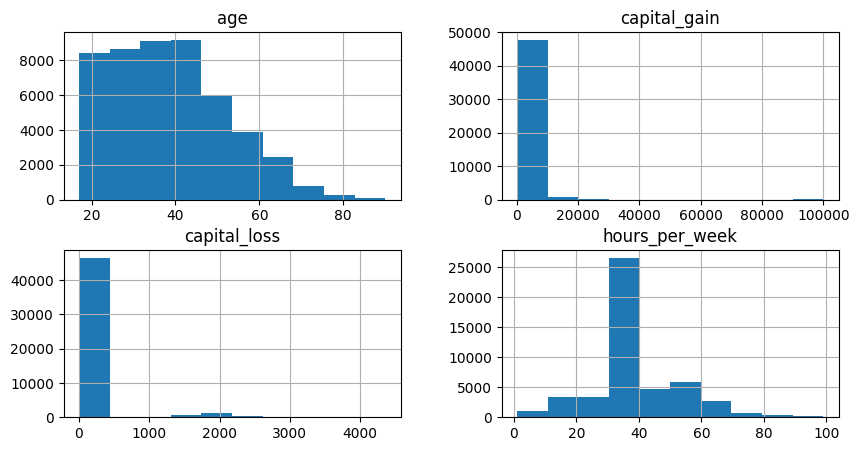

In [78]:
num_attributes.hist(figsize=(10,5));

#### How is age distributed among individuals in the data set?
**The peak age is between 20 and 50 years old**

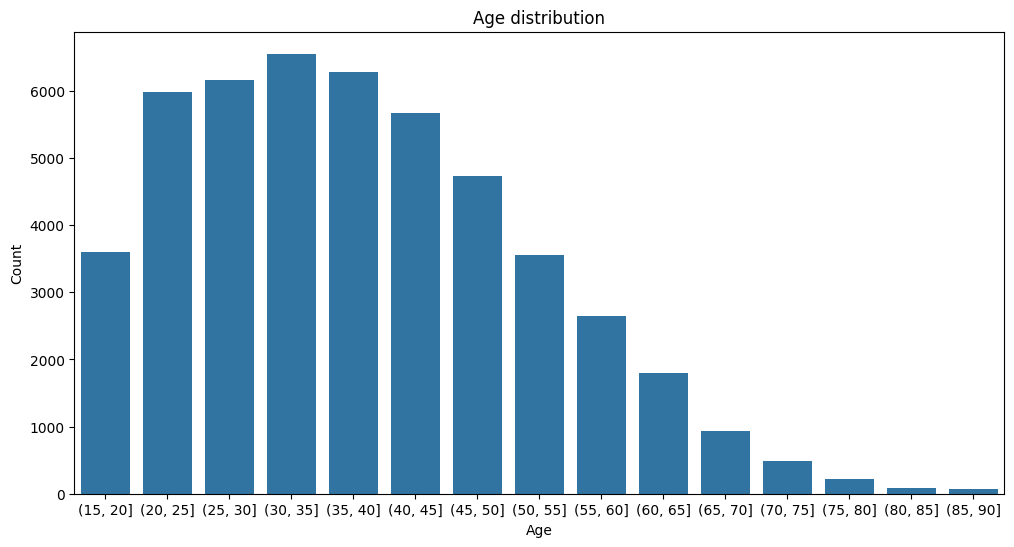

In [79]:
df_aux = df4.copy()
df_aux['binned_age'] = pd.cut(df_aux['age'], bins= np.arange(15,91,5))
df_aux = pd.DataFrame(df_aux['binned_age'].value_counts().sort_values(ascending=False)).reset_index()
df_aux.columns = ['age', 'percentage']

plt.figure(figsize=(12,6))
sns.barplot(data=df_aux, x='age', y='percentage')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age distribution')
plt.show()

#### What is the gender distribution in the dataset and how does it relate to income?
**67% are men and 33% are women.**

In [80]:
count_gender = df4['gender'].value_counts(normalize=True)
count_gender

gender
Male      0.668451
Female    0.331549
Name: proportion, dtype: float64

**30% of men and 11% of women earn over 50k**

In [81]:
df_aux = df4.groupby(['gender', 'income']).size().reset_index(name='count')

total_gender = df_aux.groupby('gender')['count'].transform('sum')
df_aux['percentage'] = (df_aux['count'] / total_gender) * 100

df_aux

,gender,income,count,percentage
0,Female,<=50K,14398,89.063467
1,Female,>50K,1768,10.936533
2,Male,<=50K,22682,69.591630
3,Male,>50K,9911,30.408370


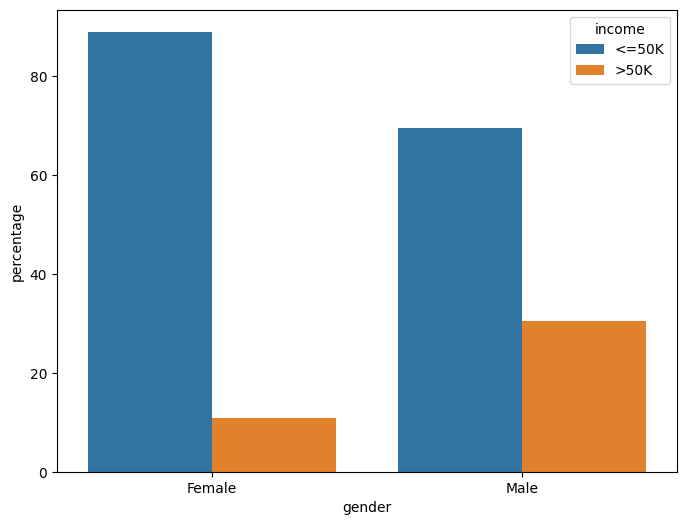

In [82]:
plt.figure(figsize=(8,6))
sns.barplot(data= df_aux, x='gender', y='percentage', hue='income')
plt.show()

#### Is there any demographic trend in relation to income, considering marital status?
**Maried-AF-Spouse and Maried-CIV-Spouse have a bigger proportion of incomes over 50K**


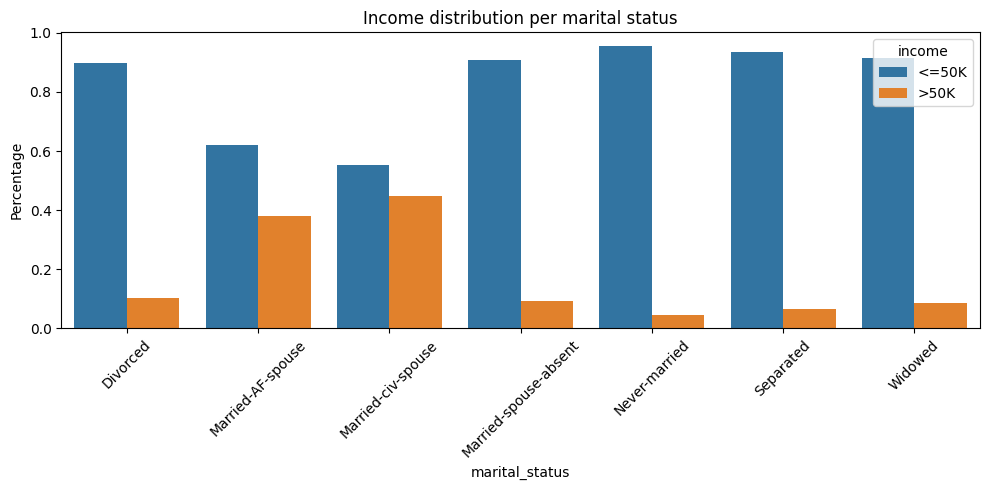

In [83]:
df_aux = df4.groupby('marital_status')['income'].value_counts(normalize=True).reset_index(name='Percentage')

plt.figure(figsize=(10,5))
sns.barplot(data=df_aux, x='marital_status', y='Percentage', hue='income')
plt.xticks(rotation=45)
plt.title('Income distribution per marital status')
plt.tight_layout()

#### Is there any demographic trend in relation to income, considering race?
**Asian-Pac-Islander and white have a bigger proportion of incomes over 50k**


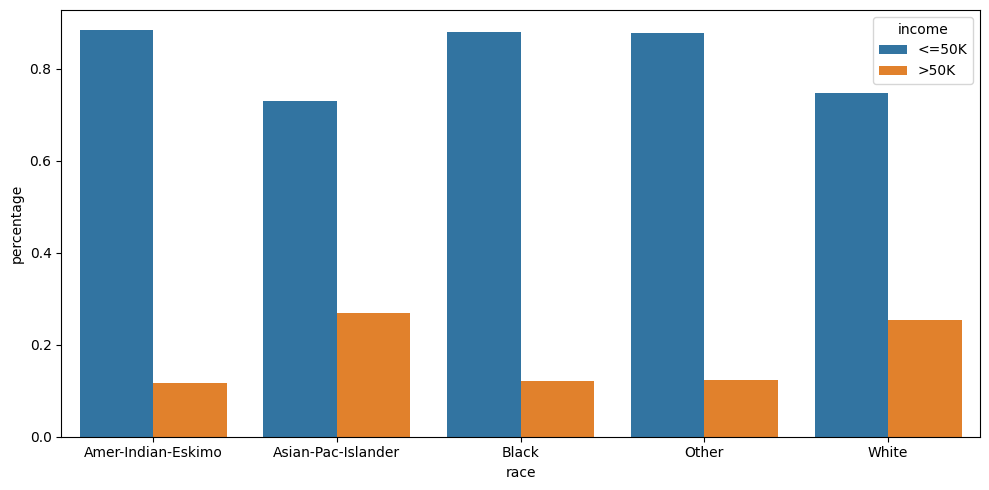

In [84]:
df_aux = df4.groupby('race')['income'].value_counts(normalize=True).reset_index(name='percentage')

plt.figure(figsize=(10,5))
sns.barplot(data=df_aux, x='race', y='percentage', hue='income')

plt.tight_layout()

#### Individuals with higher levels of education tend to have higher incomes?
**Doctorate, Masters and Prof-School have a bigger proportion of over 50K than under 50K**

<Axes: xlabel='education', ylabel='percentage'>

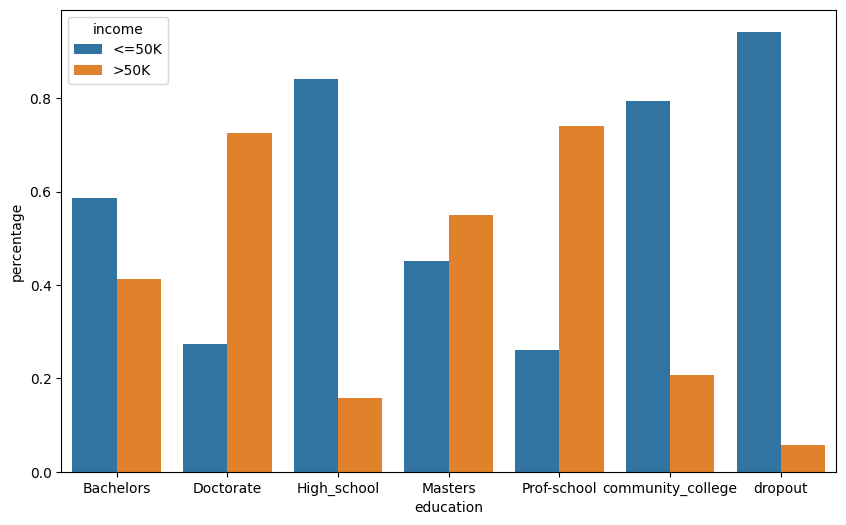

In [85]:
df_aux = df4.groupby('education')['income'].value_counts(normalize=True).reset_index(name='percentage')

plt.figure(figsize=(10,6))
sns.barplot(data=df_aux, x='education', y='percentage', hue='income')

#### What is the occupation with the highest and lowest income??
**Exec-managerial has 47% of income over 50K**

In [86]:
df_aux = pd.DataFrame(df4.groupby('occupation')['income'].value_counts(normalize=True))
df_aux2 = df_aux.xs('>50K', level='income').sort_values('proportion', ascending=False).reset_index()
df_aux2

,occupation,proportion
0,Exec-managerial,0.477882
1,Prof-specialty,0.451257
2,Armed-Forces,0.333333
3,Protective-serv,0.313646
4,Tech-support,0.290657
5,Sales,0.268182
6,Craft-repair,0.226520
7,Transport-moving,0.204333
8,Adm-clerical,0.137069
9,Machine-op-inspct,0.122720


#### Is there a relationship between the number of hours worked per week and income? Individuals who work more hours tend to have higher incomes?
**Does not seam to have a clear connection between working hours and income**

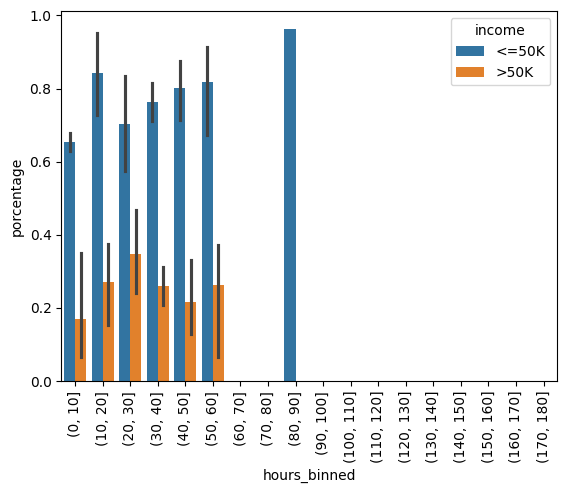

In [87]:
df_aux = df4.groupby('hours_per_week')['income'].value_counts(normalize=True).reset_index(name='porcentage')
df_aux['hours_binned'] = pd.cut(df4['hours_per_week'], bins= np.arange(0,181,10))

sns.barplot(data=df_aux, x='hours_binned', y='porcentage', hue='income')
plt.xticks(rotation=90);

# 5.0 Data Preparation

In [88]:
df5 = df4.copy()

## 5.1 Transformation

In [89]:
le = LabelEncoder()

# workclass
df5 = pd.get_dummies(df5, prefix=['workclass'], columns=['workclass'], dtype='int64')

# education
education_encoded = {'dropout': 0, 'High_school': 1, 'community_college': 2, 'Prof-school': 3, 'Bachelors': 4, 'Masters': 5, 'Doctorate': 6}
df5['education'] = df5['education'].map(education_encoded)

# marital status
df5['marital_status'] = le.fit_transform(df5['marital_status'])

# occupation
df5 = pd.get_dummies(df5, columns=['occupation'], prefix=['occupation'], dtype='int64')

# relationship  
df5 = pd.get_dummies(df5, columns=['relationship'], prefix=['relationship'], dtype='int64')

# race
df5 = pd.get_dummies(df5, columns=['race'], prefix=['race'], dtype='int64')

# native country
df5 = pd.get_dummies(df5, columns=['native_country'], prefix=['native_country'], dtype='int64')

# gender
df5['gender'] = df5['gender'].apply(lambda x: 1 if x =='Male' else 0)
df5['income'] = df5['income'].apply(lambda x: 1 if x == '>50K' else 0)

In [90]:
# Reducing the number of features

correlations = df5.corr()['income'].abs()
sorted_correlations = correlations.sort_values()
num_cols_to_drop = int( 0.8 * len(df5.columns) )
cols_to_drop = sorted_correlations.iloc[:num_cols_to_drop].index
df_dropped = df5.drop(cols_to_drop, axis=1)

<Axes: >

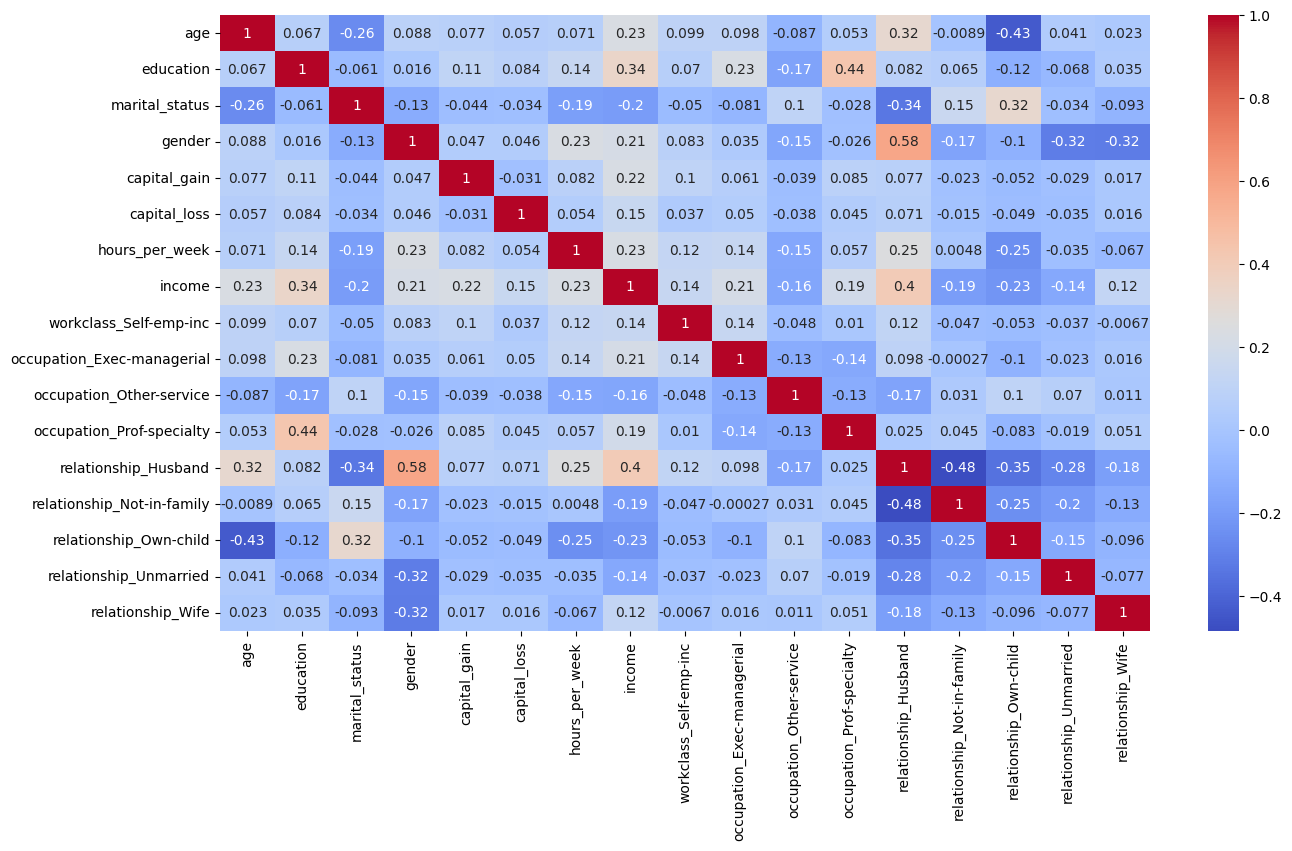

In [91]:
plt.figure(figsize=(15,8))
sns.heatmap(df_dropped.corr(), annot=True, cmap='coolwarm')

# 6.0 Feature Selection

In [92]:
df6 = df5.copy()

## 6.1 Train Test Split

In [93]:
train_df, test_df = train_test_split(df6, test_size=0.2, random_state=42)

In [94]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
 
train_x = train_df.drop('income', axis=1)
train_y = train_df['income']

test_x = test_df.drop('income', axis=1)
test_y = test_df['income']

# 7.0 Machine Learning Modeling

In [95]:
forest = RandomForestClassifier()
forest.fit(train_x, train_y)

y_hat_forest = forest.predict(test_x)
y_hat_forest_proba = forest.predict_proba(test_x)

score_forest = forest.score(test_x, test_y)
score_forest

0.8501845775225595

## 7.1 XGBoost Classifier

In [96]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(train_x, train_y)

y_hat_xgb = xgb_model.predict(test_x)
y_hat_xgb_proba = xgb_model.predict_proba(test_x)

score_xgb = xgb_model.score(test_x, test_y)
score_xgb

0.876538146021329

**With the grid, it gave the same result**

In [97]:
param_grid = {'n_estimators': [50,100,200],
              'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [3, 4, 5]
}

model = xgb.XGBClassifier()

search = GridSearchCV(model, param_grid, cv=3)
search.fit(train_x, train_y)

y_hat_grid = search.predict(test_x)
y_hat_grid_proba = search.predict_proba(test_x)

score = search.score(test_x, test_y)
score

0.876025430680886

## 7.2 Logistic Regression

In [98]:
logist_model = LogisticRegression()
logist_model.fit(train_x, train_y)

y_hat_logistic_model = logist_model.predict(test_x)
y_hat_logistic_model_proba = logist_model.predict_proba(test_x)

score_logistic = logist_model.score(test_x, test_y)
score_logistic

/home/vagner/.pyenv/versions/3.11.4/envs/venv_projetos2/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8376743232157506

## 7.3 Naive Bayes


In [99]:
naive_model = GaussianNB()
naive_model.fit(train_x, train_y)

y_hat_naive_bayes = naive_model.predict(test_x)
y_hat_naive_bayes_proba = naive_model.predict_proba(test_x)

score_naive = naive_model.score(test_x, test_y)
score_naive

0.8308039376538146

## 7.4 Gradient Boosting Classifier

In [100]:
gbm_model = GradientBoostingClassifier()
gbm_model.fit(train_x, train_y)

y_hat_gbm_model = gbm_model.predict(test_x)
y_hat_gbm_model_proba = gbm_model.predict_proba(test_x)

score_gradient = gbm_model.score(test_x, test_y)
score_gradient

0.8675143560295324

In [101]:
y_hat_ensemble_proba = (y_hat_forest_proba + y_hat_xgb_proba + y_hat_logistic_model_proba + y_hat_naive_bayes_proba + y_hat_gbm_model_proba) / 6
y_hat_ensemble = np.argmax( y_hat_ensemble_proba, axis=1 )

score_ensemble = accuracy_score(test_y, y_hat_ensemble)
score_ensemble

0.8688474159146842

In [102]:
models_results_dict = {
    'Models': ['Random Forest', 'XGBoost', 'Logistc Regression', 'Naive Bayes', 'Gradient Boost Classifier', 'Ensemble_score'],
    'Score': [score_forest, score_xgb, score_logistic, score_naive, score_gradient, score_ensemble]
}
models_results = pd.DataFrame( models_results_dict).sort_values('Score', ascending=False)
models_results


,Models,Score
1,XGBoost,0.876538
5,Ensemble_score,0.868847
4,Gradient Boost Classifier,0.867514
0,Random Forest,0.850185
2,Logistc Regression,0.837674
3,Naive Bayes,0.830804
